In [1]:
import nltk
import pandas as pd
from gensim.models import Word2Vec, KeyedVectors
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model  import LinearRegression
nltk.download('stem')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stem: Package 'stem' not found in index
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
cd /content/drive/My Drive/NLP/asap-aes

/content/drive/My Drive/NLP/asap-aes


In [0]:
n1_column = pd.read_excel('training_set_rel3.xls', index_col=0)  


In [5]:
n1_column.columns

Index(['essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2',
       'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3',
       'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1',
       'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5',
       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
       'rater3_trait4', 'rater3_trait5', 'rater3_trait6'],
      dtype='object')

In [0]:
n1_column.columns
n1_column = n1_column.iloc[:,[0,1,5,8]]
n1_column = n1_column[n1_column.essay_set == 2]

In [0]:
n1_column['domain1_score'] = n1_column['domain1_score'].astype('int32')
n1_column['domain1_score'] = n1_column['domain1_score'].astype(str)
n1_column['domain2_score'] = n1_column['domain2_score'].astype('int32')
n1_column['domain2_score'] = n1_column['domain2_score'].astype(str)

In [8]:
n1_column

,essay_set,essay,domain1_score,domain2_score
essay_id,,,,
2978,2,Certain materials being removed from libraries...,4,4
2979,2,Write a persuasive essay to a newspaper reflec...,1,1
2980,2,Do you think that libraries should remove cert...,2,3
2981,2,"In @DATE1's world, there are many things found...",4,4
2982,2,In life you have the 'offensive things'. The l...,4,4
...,...,...,...,...
4773,2,The author is writting about taking books off ...,3,3
4774,2,"I do not think that materials, such as books, ...",3,3
4775,2,"Yes we should keep the books,music,movies,an m...",2,2


###RNN_______________________

In [9]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import numpy as np 
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
import matplotlib.pyplot as plt
import keras 
from keras import backend as K
from keras import layers
from plotly import __version__
%matplotlib inline

Using TensorFlow backend.


In [0]:
import re
df = n1_column.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = text.replace('x', '')
    #    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split()) # remove stopwors from text
    return text
df['essay'] = df['essay'].apply(clean_text)
df['essay'] = df['essay'].str.replace('\d+', '')

##D1

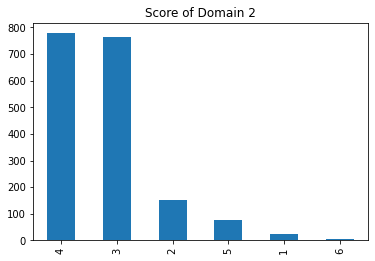

In [11]:
df['domain1_score'].value_counts().sort_values(ascending=False).plot(kind='bar', 
                                                                title='Score of Domain 2')

In [12]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 2000
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['essay'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15393 unique tokens.


In [13]:
X = tokenizer.texts_to_sequences(df['essay'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1800, 2000)


In [14]:
Y = pd.get_dummies(n1_column.domain1_score).values
#Y = n1_column['domain1_score'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1800, 6)


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1350, 2000) (1350, 6)
(450, 2000) (450, 6)


In [16]:


model_1 = Sequential() 
model_1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1],trainable=False)) 
model_1.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_1.add(Dense(6, activation='softmax'))
model_1.compile(loss= 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
 # -------------------------------------------------------------------------------------------------------#
history = model_1.fit(X_train,
                      Y_train,
                      epochs=5, 
                      batch_size=64,
                      validation_split=0.1,
                      callbacks=
                      [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')])


Train on 1215 samples, validate on 135 samples
Epoch 1/5
1215/1215 [==============================] - 43s 36ms/step - loss: 1.2887 - accuracy: 0.4198 - val_loss: 1.3414 - val_accuracy: 0.4148
Epoch 2/5
1215/1215 [==============================] - 42s 35ms/step - loss: 1.1463 - accuracy: 0.4593 - val_loss: 1.2776 - val_accuracy: 0.4074
Epoch 3/5
1215/1215 [==============================] - 42s 35ms/step - loss: 1.1509 - accuracy: 0.4346 - val_loss: 1.2675 - val_accuracy: 0.3778
Epoch 4/5
1215/1215 [==============================] - 49s 41ms/step - loss: 1.1430 - accuracy: 0.4321 - val_loss: 1.3081 - val_accuracy: 0.4148
Epoch 5/5
1215/1215 [==============================] - 43s 35ms/step - loss: 1.1413 - accuracy: 0.4477 - val_loss: 1.2776 - val_accuracy: 0.4074


In [18]:
accr = model_2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

NameError: ignored

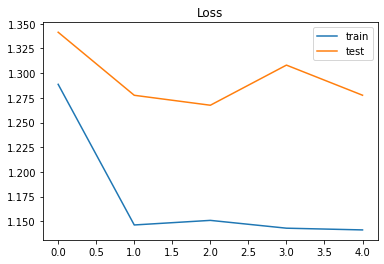

In [19]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

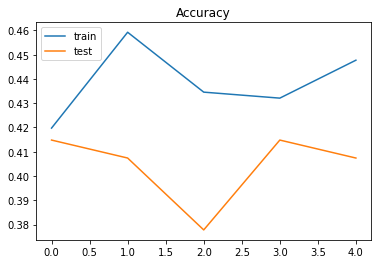

In [20]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [0]:
def find_d1(text):
  input_d = clean_text(text)
  seq = tokenizer.texts_to_sequences(input_d)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model_1.predict(padded)
  buf = []
  buf_2 = []
  for i in range(0,6):
    for n in pred:
      buf.append(n[i])
    buf_1 = np.mean(buf)
    buf_2.append(buf_1)
  labels = [1,2,3,4,5,6]
  d1 = labels[np.argmax(buf_2)]
  return d1

##D2

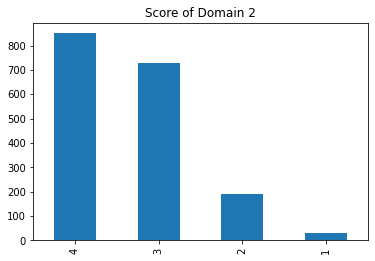

In [22]:
df['domain2_score'].value_counts().sort_values(ascending=False).plot(kind='bar', 
                                                                title='Score of Domain 2')

In [23]:
Y = pd.get_dummies(n1_column.domain2_score).values
#Y = n1_column['domain2_score'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1800, 4)


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1350, 2000) (1350, 4)
(450, 2000) (450, 4)


In [25]:


model_2 = Sequential() # To create the modeling object for stacking the following layers.
model_2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1],trainable=False)) # the model will take as input an integer matrix of size (batch, input_length).
model_2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_2.add(Dense(4, activation='softmax'))
model_2.compile(loss= 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model_2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')])


Train on 1215 samples, validate on 135 samples
Epoch 1/5
1215/1215 [==============================] - 43s 36ms/step - loss: 1.1206 - accuracy: 0.4296 - val_loss: 1.0568 - val_accuracy: 0.5185
Epoch 2/5
1215/1215 [==============================] - 43s 35ms/step - loss: 1.0356 - accuracy: 0.4782 - val_loss: 1.0554 - val_accuracy: 0.5185
Epoch 3/5
1215/1215 [==============================] - 43s 35ms/step - loss: 1.0269 - accuracy: 0.4576 - val_loss: 1.0576 - val_accuracy: 0.5185
Epoch 4/5
1215/1215 [==============================] - 43s 35ms/step - loss: 1.0012 - accuracy: 0.4790 - val_loss: 1.0679 - val_accuracy: 0.5111
Epoch 5/5
1215/1215 [==============================] - 43s 35ms/step - loss: 1.0068 - accuracy: 0.4749 - val_loss: 1.0697 - val_accuracy: 0.5185


In [26]:
accr = model_2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

450/450 [==============================] - 6s 13ms/step
Test set
  Loss: 0.995
  Accuracy: 0.462


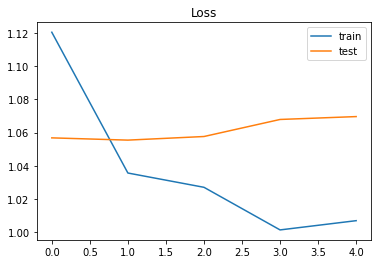

In [27]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

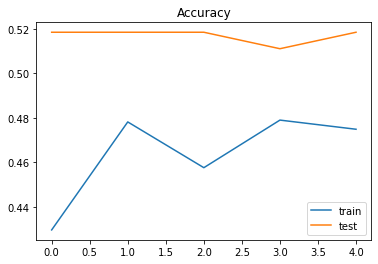

In [28]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [0]:
def find_d2(text):
  input_d = clean_text(text)
  seq = tokenizer.texts_to_sequences(input_d)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model_2.predict(padded)
  buf = []
  buf_2 = []
  for i in range(0,4):
    for n in pred:
      buf.append(n[i])
    buf_1 = np.mean(buf)
    buf_2.append(buf_1)
  labels = [1,2,3,4]
  d2 = labels[np.argmax(buf_2)]
  return d2

##GSL

In [30]:
!pip install pyspellchecker
!pip install --upgrade language_tool_python
!pip install lexicalrichness
from lexicalrichness import LexicalRichness

Requirement already up-to-date: language_tool_python in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [0]:
def cal_GSL(data):
  data = data.split()
  init_len = len(data)
  for j, i in enumerate(data):
    #print(i,j)
    if '@' in i:
      data[j] = ''
    else: data[j] = i 
  data = ' '.join(data)
  data_clean = clean_text(data)
  #Count number of sentence 
  sentence_num = data.count('. ')
  sentence_num = sentence_num + data.count('? ')
  sentence_num = sentence_num + data.count('?')
  sentence_num = sentence_num + data.count('?\' ')
  sentence_num = sentence_num + data.count('! ')
  sentence_num = sentence_num + data.count('!')
  sentence_num = sentence_num + data.count('!\' ')
  sentence_num = sentence_num + data.count('\' ')
  sentence_num = sentence_num + data.count('\" ')

  #Check Grammar and Spelling 
  import language_tool_python
  tool = language_tool_python.LanguageTool('en-US')
  matches = tool.check(data)

  #Spelling error count
  s_score = 0
  for i in range(len(matches)):
    keep_buf = list(matches[i])
    if keep_buf[1] == 'Possible spelling mistake found.':
      s_score = s_score+1

  lex = LexicalRichness(data)
  L = lex.ttr
  G = (sentence_num-(len(matches)-s_score))/sentence_num
  S = (init_len-s_score)/init_len
  GS = G*S
  return GS,L,G,S,matches, sentence_num, init_len, lex

In [0]:
def transformation_table(d1,d2,gs,l):
  #Task Achievement : ta
  #Coherence and Cohesion : cc 
  #Lexical Resource : lr
  #Grammatical Range and Accuracy : gra
  ta = d1
  cc = d2
  lr = d1*l
  gra = d2*gs
  total = ta+cc+lr+gra
  band = 0
  if total <= 4:
    band = 1
  elif total > 4 and total <= 5:
    band = 2
  elif total > 5 and total <= 6:
    band = 3
  elif total > 6 and total <= 8:
    band = 4
  elif total > 8 and total <= 9:
    band = 5
  elif total > 9 and total <= 12:
    band = 6
  elif total > 12 and total <= 14:
    band = 7
  elif total > 14 and total <= 18:
    band = 8
  elif total > 18 :
    band = 9
  return band, total

In [0]:
def run(text):
  input_d = clean_text(text)
  seq = tokenizer.texts_to_sequences(input_d)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  d1 = find_d1(text)
  d2 = find_d2(text)
  GSL = cal_GSL(text)
  band, final_score = transformation_table(d1,d2,GSL[0],GSL[1])
  
  mst = list(GSL[4])
  print("(D1) Writing Application (bad 1-6 good)  :",d1)
  print("(D2) Language Convention (bad 1-4 good):",d2)
  print("Lexical Richness ratio :", GSL[1])
  print("Grammar error ration :", GSL[2])
  print("Spelling error ratio :", GSL[3])
  print("The closer to 1 it is, the better performance you are!!!")
  print("----------------------------------------------------------------")
  print("What is your mistaken :\n")
  for i, j in enumerate(mst):
    buf = list(j)
    print( "Comment "+str(i+1)+" : "+buf[1])
    print("Where : " + buf[3])
  print("----------------------------------------------------------------")

  return band, final_score, mst


In [55]:
text = input(" Your IELTS Writing Task 2")
band, final_score, mst = run(text)
print("Your IELTS band is : ",band)
print("Your total score is : ",final_score)

 Your IELTS Writing Task 2It is certainly said that learning is an ongoing process .Every person learn something new according to their age, experience, knowledge and education. According to my point of view it is always better to have _teacher or guide for study.   One teacher has adequate knowledge to teach their student. He knows all the possible ways to make subject easier for the students, moreover, he teaches them in an effective manner. For example, some students are weak in some subjects but a teacher always guides them according to their mental capacity. He teaches them as fun. Some people can learn better in group by discuss the topics with others. In class people can know the views of others, even they know how we can learn effectively. Where the teacher always gives an easy direction to learn.  In the today’s competitive world, everybody is busy, some people think that rather to waste their time to go for classes they can learn better their subject _. They can attend online